# 原文
源码来源：https://matthewearl.github.io/2015/07/28/switching-eds-with-python/

shape_predictor_68_face_landmarks模型下载链接:     
https://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2/download

In [ ]:
![ ! -f shape_predictor_68_face_landmarks.dat ] && wget https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2

![ ! -f shape_predictor_68_face_landmarks.dat ] && bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


In [1]:
import cv2
import dlib
import numpy
import sys
import matplotlib.pyplot as plt

PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"  # 68个关键点landmarks的模型文件
SCALE_FACTOR = 1 # 图像的放缩比
FEATHER_AMOUNT = 15  # 羽化边界范围，越大，羽化能力越大，一定要奇数，不能偶数

#　68个点
FACE_POINTS = list(range(17, 68))  # 脸
MOUTH_POINTS = list(range(48, 61))  # 嘴巴
RIGHT_BROW_POINTS = list(range(17, 22))  # 右眉毛
LEFT_BROW_POINTS = list(range(22, 27))  # 左眉毛
RIGHT_EYE_POINTS = list(range(36, 42))  # 右眼睛
LEFT_EYE_POINTS = list(range(42, 48))  # 左眼睛
NOSE_POINTS = list(range(27, 35))  # 鼻子
JAW_POINTS = list(range(0, 17))  # 下巴

# 选取用于叠加在第一张脸上的第二张脸的面部特征
# 特征点包括左右眼、眉毛、鼻子和嘴巴
# 是否数量变多之后，会有什么干扰吗?
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]  
# 眼睛 ，眉毛             2 * 22
# 鼻子，嘴巴   分开来

# 定义用于颜色校正的模糊量，作为瞳孔距离的系数
COLOUR_CORRECT_BLUR_FRAC = 0.6

# 实例化脸部检测器
detector = dlib.get_frontal_face_detector()
# 加载训练模型
# 并实例化特征提取器
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [2]:
# 定义了两个类处理意外
class TooManyFaces(Exception): 
    pass

class NoFaces(Exception):
    pass


def get_landmarks(im):
    '''
    通过predictor 拿到68 landmarks
    '''
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return numpy.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])   # 68*2的矩阵

def annotate_landmarks(im, landmarks):
    '''
    人脸关键点，画图函数
    '''
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

def draw_convex_hull(im, points, color):
    '''
    # 绘制凸多边形 计算凸包
    '''
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    '''获取面部特征部分（眉毛、眼睛、鼻子以及嘴巴）的图像掩码。
    图像掩码作用于原图之后，原图中对应掩码部分为白色的部分才能显示出来，黑色的部分则不予显示，因此通过图像掩码我们就能实现对图像“裁剪”。
    效果参考：https://dn-anything-about-doc.qbox.me/document-uid242676labid2260timestamp1477921310170.png/wm
    get_face_mask()的定义是为一张图像和一个标记矩阵生成一个遮罩，它画出了两个白色的凸多边形：一个是眼睛周围的区域，
    一个是鼻子和嘴部周围的区域。之后它由11个(FEATHER_AMOUNT)像素向遮罩的边缘外部羽化扩展，可以帮助隐藏任何不连续的区域。
    '''
    im = numpy.zeros(im.shape[:2], dtype=numpy.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    im = numpy.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im
    
def transformation_from_points(points1, points2):
    """
    Return an affine transformation [s * R | T] such that:
        sum ||s*R*p1,i + T - p2,i||^2
    is minimized.
    """
    # Solve the procrustes problem by subtracting centroids, scaling by the
    # standard deviation, and then using the SVD to calculate the rotation. See
    # the following for more details:
    #   https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem

    points1 = points1.astype(numpy.float64)
    points2 = points2.astype(numpy.float64)

    c1 = numpy.mean(points1, axis=0)
    c2 = numpy.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = numpy.std(points1)
    s2 = numpy.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = numpy.linalg.svd(points1.T * points2)

    # The R we seek is in fact the transpose of the one given by U * Vt. This
    # is because the above formulation assumes the matrix goes on the right
    # (with row vectors) where as our solution requires the matrix to be on the
    # left (with column vectors).
    R = (U * Vt).T

    return numpy.vstack([numpy.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         numpy.matrix([0., 0., 1.])])

def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s

def warp_im(im, M, dshape):
    '''
    由 get_face_mask 获得的图像掩码还不能直接使用，因为一般来讲用户提供的两张图像的分辨率大小很可能不一样，而且即便分辨率一样，
    图像中的人脸由于拍摄角度和距离等原因也会呈现出不同的大小以及角度，所以如果不能只是简单地把第二个人的面部特征抠下来直接放在第一个人脸上，
    我们还需要根据两者计算所得的面部特征区域进行匹配变换，使得二者的面部特征尽可能重合。
    
    仿射函数，warpAffine，能对图像进行几何变换
        三个主要参数，第一个输入图像，第二个变换矩阵 np.float32 类型，第三个变换之后图像的宽高
    
    对齐主要函数
    '''
    output_im = numpy.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def correct_colours(im1, im2, landmarks1):
    '''
    修改皮肤颜色，使两张图片在拼接时候显得更加自然。
    '''
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * numpy.linalg.norm(
                              numpy.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              numpy.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(numpy.float64) * im1_blur.astype(numpy.float64) /
                                                im2_blur.astype(numpy.float64))

In [3]:
# 换脸函数
def Switch_face(Base_path,cover_path):
    im1, landmarks1 = read_im_and_landmarks(Base_path)  # 底图
    im2, landmarks2 = read_im_and_landmarks(cover_path)  # 贴上来的图
    
    if len(landmarks1) == 0 & len(landmarks2) == 0 :
        raise ImproperNumber("Faces detected is no face!")
    if len(landmarks1) > 1 & len(landmarks2) > 1 :
        raise ImproperNumber("Faces detected is more than 1!")
    
    M = transformation_from_points(landmarks1[ALIGN_POINTS],
                                   landmarks2[ALIGN_POINTS])
    mask = get_face_mask(im2, landmarks2)
    warped_mask = warp_im(mask, M, im1.shape)
    combined_mask = numpy.max([get_face_mask(im1, landmarks1), warped_mask],
                              axis=0)
    warped_im2 = warp_im(im2, M, im1.shape)
    warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

    output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask
    return output_im

# 人脸对齐函数
def face_Align(Base_path,cover_path):
    im1, landmarks1 = read_im_and_landmarks(Base_path)  # 底图
    im2, landmarks2 = read_im_and_landmarks(cover_path)  # 贴上来的图
    
    if len(landmarks1) == 0 & len(landmarks2) == 0 :
        raise ImproperNumber("Faces detected is no face!")
    if len(landmarks1) > 1 & len(landmarks2) > 1 :
        raise ImproperNumber("Faces detected is more than 1!")
    
    M = transformation_from_points(landmarks1[ALIGN_POINTS],
                                   landmarks2[ALIGN_POINTS])
    warped_im2 = warp_im(im2, M, im1.shape)
    return warped_im2

In [4]:
'''
换脸
Base_path:是底图
cover_path：从该图抽取内容覆盖到底图上
'''
FEATHER_AMOUNT = 23

Base_path = 'huanzhu.jpg'
cover_path = 'linzhiling.jpg'
output_im = Switch_face(Base_path,cover_path)

cv2.imwrite('output.jpg', output_im)  # 换脸数据保存

True

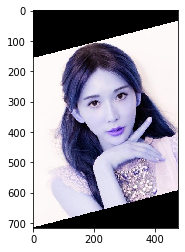

In [5]:
'''
人脸对齐-dlib
Base_path:模板图
cover_path：需对齐的图
'''
FEATHER_AMOUNT = 19  # 匹配的时候，特征数量，现在是以11个点为基准点  11  15  17 

Base_path = 'huanzhu.jpg'
cover_path = 'linzhiling.jpg'
warped_mask = face_Align(Base_path,cover_path)

%matplotlib inline
plt.subplot(111)
plt.imshow(warped_mask)     #　数据展示

In [6]:
# 关键点定位 画图函数
    # 画圈 + 数字
def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

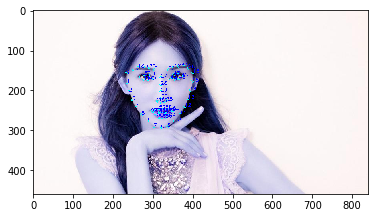

In [7]:
im1, landmarks1 = read_im_and_landmarks('linzhiling.jpg')  # 底图
im1 = annotate_landmarks(im1, landmarks1)

%matplotlib inline
plt.subplot(111)
plt.imshow(im1)